In [1]:
from skimage.io import imread
import napari_segment_blobs_and_things_with_membranes
from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling
from napari_segment_blobs_and_things_with_membranes import seeded_watershed
from napari_segment_blobs_and_things_with_membranes import local_minima_seeded_watershed
from skimage.filters import gaussian
from pyclesperanto_prototype import imshow
from skimage.io import imread
from pyclesperanto_prototype import imshow
import pandas as pd
import numpy as np
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage import io, filters, measure, segmentation


In [2]:
#import image-will later change to get from folder

cells = imread('/home/jadeaphillips/Quantitative_Bio_Image_Analysis_with_Python_2022-main/data/eccentricity/MAX_dsrflgldssr4vsr5_2025_06_04__14_59_10 proj.tif')


#get the size of the image
cells.shape



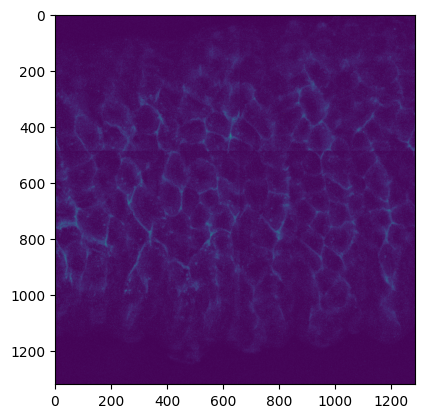

In [3]:

#split into two channels as above
dapi=cells[0,:,:]
lgl=cells[1,:,:]

plt.imshow(lgl)


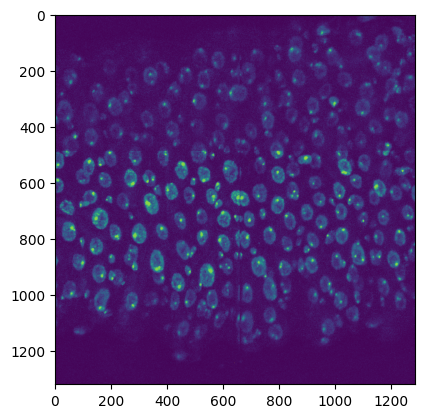

In [4]:
plt.imshow(dapi)

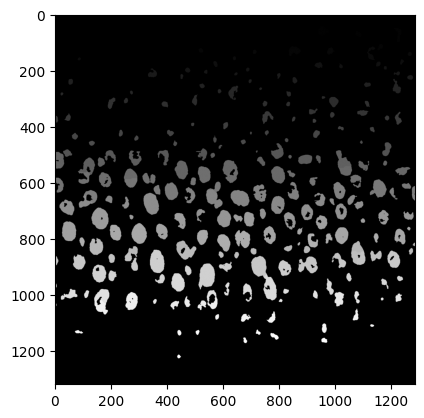

In [5]:
labeled_nuclei=voronoi_otsu_labeling(dapi, spot_sigma=10, outline_sigma=2)
plt.imshow(labeled_nuclei, cmap='grey')

(np.float64(-0.5), np.float64(1284.5), np.float64(1319.5), np.float64(-0.5))

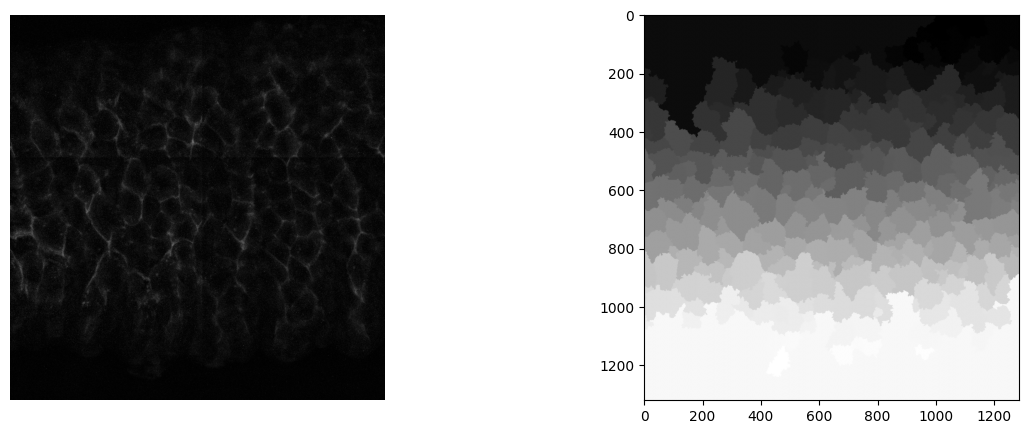

In [6]:
#labeled_lgl=voronoi_otsu_labeling(lgl, spot_sigma=10, outline_sigma=2)
#plt.imshow(labeled_lgl, cmap='gray')

labeled_cells = seeded_watershed(lgl, labeled_nuclei)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
(axes[0].imshow(lgl, cmap = 'grey'))
axes[0].axis('off')

(axes[1].imshow(labeled_cells, cmap = 'grey'))
axes[0].axis('off')

(np.float64(-0.5), np.float64(1284.5), np.float64(1319.5), np.float64(-0.5))

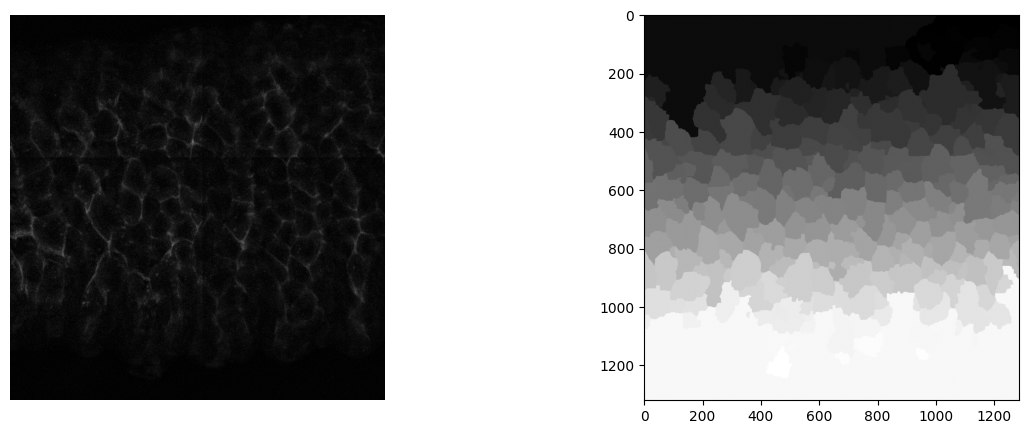

In [7]:
#make the outlines of the membrane more accurate

blurred = gaussian(lgl, sigma=3)

labeled_cells = seeded_watershed(blurred, labeled_nuclei)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
(axes[0].imshow(lgl, cmap = 'grey'))
axes[0].axis('off')

(axes[1].imshow(labeled_cells, cmap = 'grey'))
axes[0].axis('off')



(np.float64(-0.5), np.float64(1284.5), np.float64(1319.5), np.float64(-0.5))

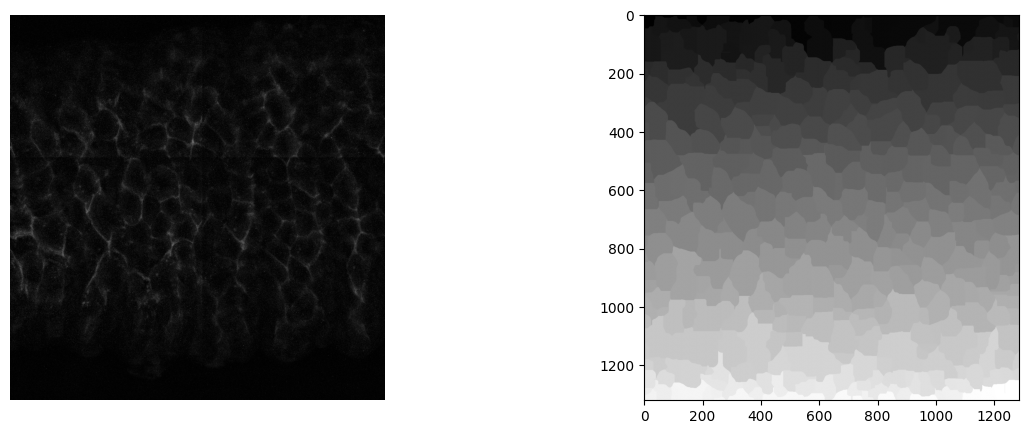

In [8]:
#fine tune

labeles_cells3 = local_minima_seeded_watershed(lgl, outline_sigma=7)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
(axes[0].imshow(lgl, cmap = 'grey'))
axes[0].axis('off')

(axes[1].imshow(labeles_cells3, cmap = 'grey'))
axes[0].axis('off')

(np.float64(-0.5), np.float64(1284.5), np.float64(1319.5), np.float64(-0.5))

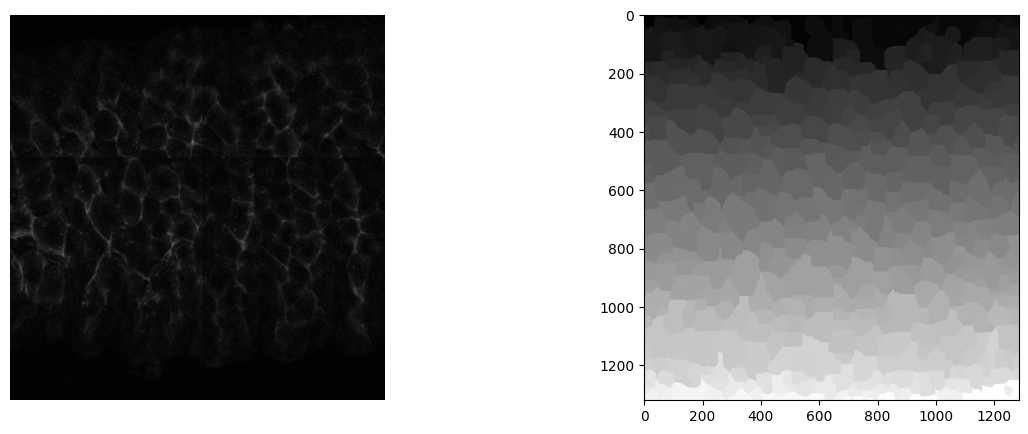

In [9]:
#multiple cells stuck together
#configures how close cells are
labeles_cells4 = local_minima_seeded_watershed(lgl, spot_sigma=9, outline_sigma=7)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
(axes[0].imshow(lgl, cmap = 'grey'))
axes[0].axis('off')

(axes[1].imshow(labeles_cells4, cmap = 'grey'))
axes[0].axis('off')

In [30]:

properties = measure.regionprops(labeles_cells4, intensity_image=lgl)
properties[0:5]

statistics = {
    'area':       [p.area               for p in properties],
    'eccentricity':       [p.eccentricity     for p in properties],
    'major_axis': [p.major_axis_length  for p in properties],
    'perimeter': [p.perimeter for p in properties],
    'csi': [p.perimeter/math.sqrt(p.area) for p in properties]
}

df = pd.DataFrame(statistics)
df

#print(properties)

#df=pd.DataFrame(properties)
df.to_csv("/home/jadeaphillips/Quantitative_Bio_Image_Analysis_with_Python_2022-main/data/eccentricity/cellshape_analysis.csv")

In [31]:

# A good practice is to wrap the main logic in a function for reusability.
def visualize_eccentricity(label_image, eccentricities, colormap_name='viridis'):
    """
    Color-codes a labeled image based on eccentricity values.

    Args:
        label_image (np.ndarray): A 2D NumPy array where each pixel
                                  belongs to a labeled object (e.g., cell).
                                  Background is assumed to be 0.
        eccentricities (list or dict): A list or dictionary containing the
                                     eccentricity value for each label ID.
                                     Eccentricity should be in the range [0, 1].
        colormap_name (str): The name of the matplotlib colormap to use.

    Returns:
        np.ndarray: A 3D NumPy array representing the color-coded image.
    """
    # Get a colormap from matplotlib
    colormap = cm.get_cmap(colormap_name)

    # Normalize the eccentricity values to a [0, 1] range to map to the colormap.
    # We use a try-except block to handle cases where no cells are found.
    try:
        min_val = min(eccentricities)
        max_val = max(eccentricities)
        if max_val == min_val:
            normalized_eccentricities = [0.5] * len(eccentricities) # Use a neutral color if all values are the same
        else:
            normalized_eccentricities = [
                (e - min_val) / (max_val - min_val) for e in eccentricities
            ]
    except ValueError:
        print("No cells found to calculate eccentricity for.")
        return np.zeros(label_image.shape + (3,)) # Return an empty black image

    # Create an empty RGB image to draw the color-coded cells onto
    color_coded_image = np.zeros(label_image.shape + (3,), dtype=np.float64)

    # Iterate over each unique label (cell) in the image
    for i, label_id in enumerate(np.unique(label_image)):
        if label_id == 0:
            continue  # Skip the background (label 0)

        # Get the normalized eccentricity for the current label
        normalized_eccentricity = normalized_eccentricities[i-1] # Subtract 1 because label IDs start from 1, not 0

        # Get the color from the colormap based on the normalized eccentricity
        color = colormap(normalized_eccentricity)[:3]  # The [:3] gets the RGB values

        # Find the pixels that belong to the current label
        cell_mask = label_image == label_id

        # Apply the color to the corresponding pixels in the output image
        color_coded_image[cell_mask] = color

    return color_coded_image





/tmp/ipykernel_1116/650799780.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(colormap_name)


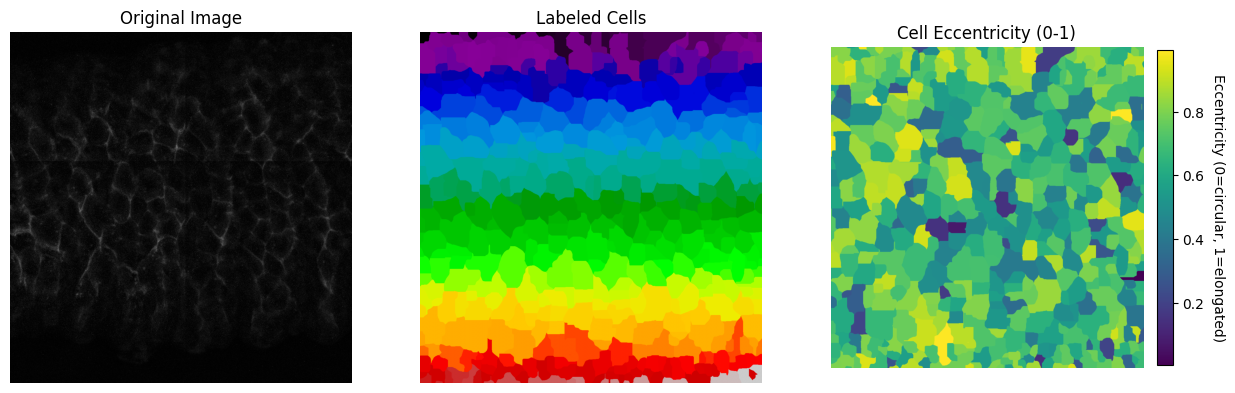

In [32]:
eccentricity=[p.eccentricity     for p in properties]

color_coded_image = visualize_eccentricity(labeles_cells4, eccentricity, colormap_name='viridis')
#plt.imshow(color_coded_image)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(lgl, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Labeled image
axes[1].imshow(labeles_cells4, cmap='nipy_spectral')
axes[1].set_title('Labeled Cells')
axes[1].axis('off')

# Color-coded eccentricity map
im = axes[2].imshow(color_coded_image)
axes[2].set_title('Cell Eccentricity (0-1)')
axes[2].axis('off')

# Add a color bar to show the scale of eccentricity
cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label('Eccentricity (0=circular, 1=elongated)', rotation=270, labelpad=15)


In [37]:
#plot for cell shape index

/tmp/ipykernel_1116/650799780.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(colormap_name)


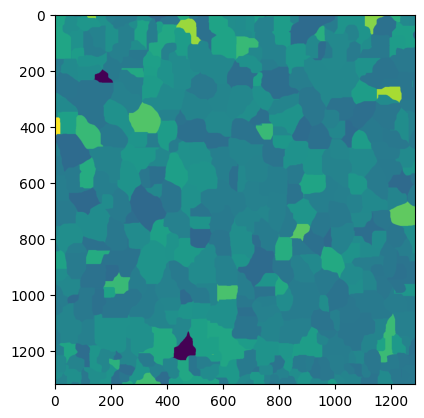

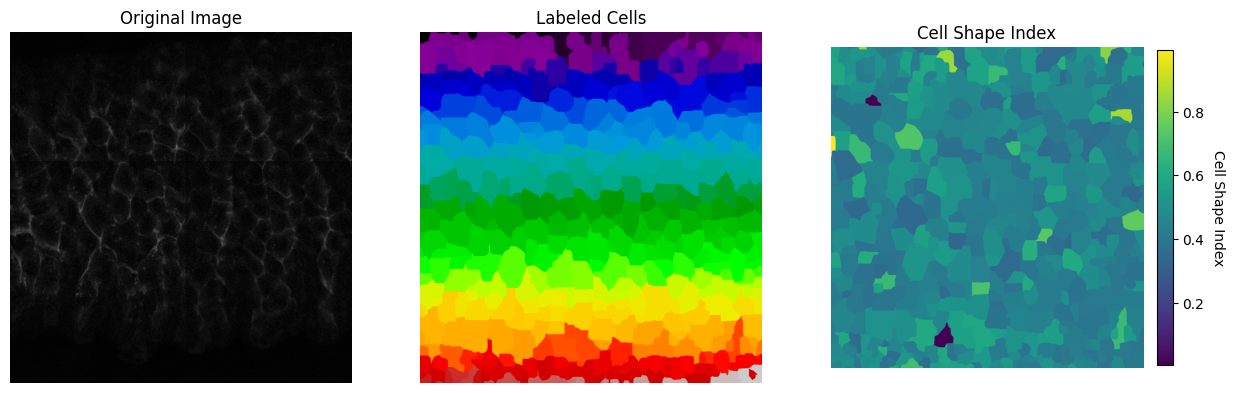

In [36]:
csi=[p.perimeter/math.sqrt(p.area) for p in properties]
color_coded_image = visualize_eccentricity(labeles_cells4, csi, colormap_name='viridis')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(lgl, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Labeled image
axes[1].imshow(labeles_cells4, cmap='nipy_spectral')
axes[1].set_title('Labeled Cells')
axes[1].axis('off')

# Color-coded eccentricity map
im = axes[2].imshow(color_coded_image)
axes[2].set_title('Cell Shape Index')
axes[2].axis('off')

# Add a color bar to show the scale of eccentricity
cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label('Cell Shape Index', rotation=270, labelpad=15)